# Trabalho Final Chatbots - Zelador Virtual

**FURB - Data Science - Turma 02**<br>
**Alunos:**<br>
Felipe Eduardo Gomes <br>
João Carlos Haag <br>
Marco Antonio Batista<br>

> Fonte utilizado como referência para as métricas do Watson: https://github.com/sergiogama/notebook/blob/master/WA-QA.ipynb
---



In [1]:
pip install ibm_watson

     |████████████████████████████████| 389kB 22.0MB/s 
     |████████████████████████████████| 204kB 34.7MB/s 
  Created wheel for ibm-watson: filename=ibm_watson-5.1.0-cp37-none-any.whl size=375439 sha256=01677f1b032eb81ce145b23e951772c27e832df0cc357be75aecab30c2b1f1ed
  Stored in directory: /root/.cache/pip/wheels/49/6d/cf/1d91261b96363da78bf9b02699fd2262e6b5dad179500690c1
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.10.0-cp37-none-any.whl size=60912 sha256=11233f640903d4a3feb23a8dcba39f04eaa25e61d407ff6c8e8d398ca1848da0
  Stored in directory: /root/.cache/pip/wheels/4a/4e/48/b02ad6dc75235fc4c0742d4e99571fe7d729e60bf365105be4
Successfully built ibm-watson ibm-cloud-sdk-core


In [2]:
import re
import os
import sys
import time
import configparser
from datetime import date

In [3]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from termcolor import colored, cprint

In [4]:
from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

### Credenciais para conectar no Watson

In [5]:
WAS_WORKSPACE = '9b73f721-3ad5-4ac7-9941-fa31bf4d7dad'
WAS_API_KEY = 'P3GXw717zMAn9HDslnhENdjK0B08JvJb9csy6NofGEtx'
WAS_URL = 'https://api.us-south.assistant.watson.cloud.ibm.com/instances/4c76dd25-4d06-4cbb-b1fe-ff97e06d5423/'

In [6]:
authenticator = IAMAuthenticator(WAS_API_KEY)
assistant = AssistantV1(
    version='2020-04-01',
    authenticator=authenticator
)

assistant.set_service_url(WAS_URL)
original_workspace_id = WAS_WORKSPACE

### Validar se a skill está pronta para receber chamadas

In [7]:
def check_wksp_status(check_workspace_id):
    wksp_notready = True
    
    while(wksp_notready == True):
        print('Testando Workspace...' + check_workspace_id)
        workspace = assistant.get_workspace(workspace_id=check_workspace_id, export=True).get_result()

        print('Status do workspace: {0}'.format(workspace['status']))
        if workspace['status'] == 'Available':
            wksp_notready = False
            print('Pronto para conexão!')
        else:
            print('No momento estou em treinamento...espere 30 segundos e tente novamente.')
            time.sleep(30)

In [8]:
check_wksp_status(original_workspace_id)

Testando Workspace...9b73f721-3ad5-4ac7-9941-fa31bf4d7dad
Status do workspace: Available
Pronto para conexão!


### **Métricas**

---
#### 1) Número de ocorrências por intenções


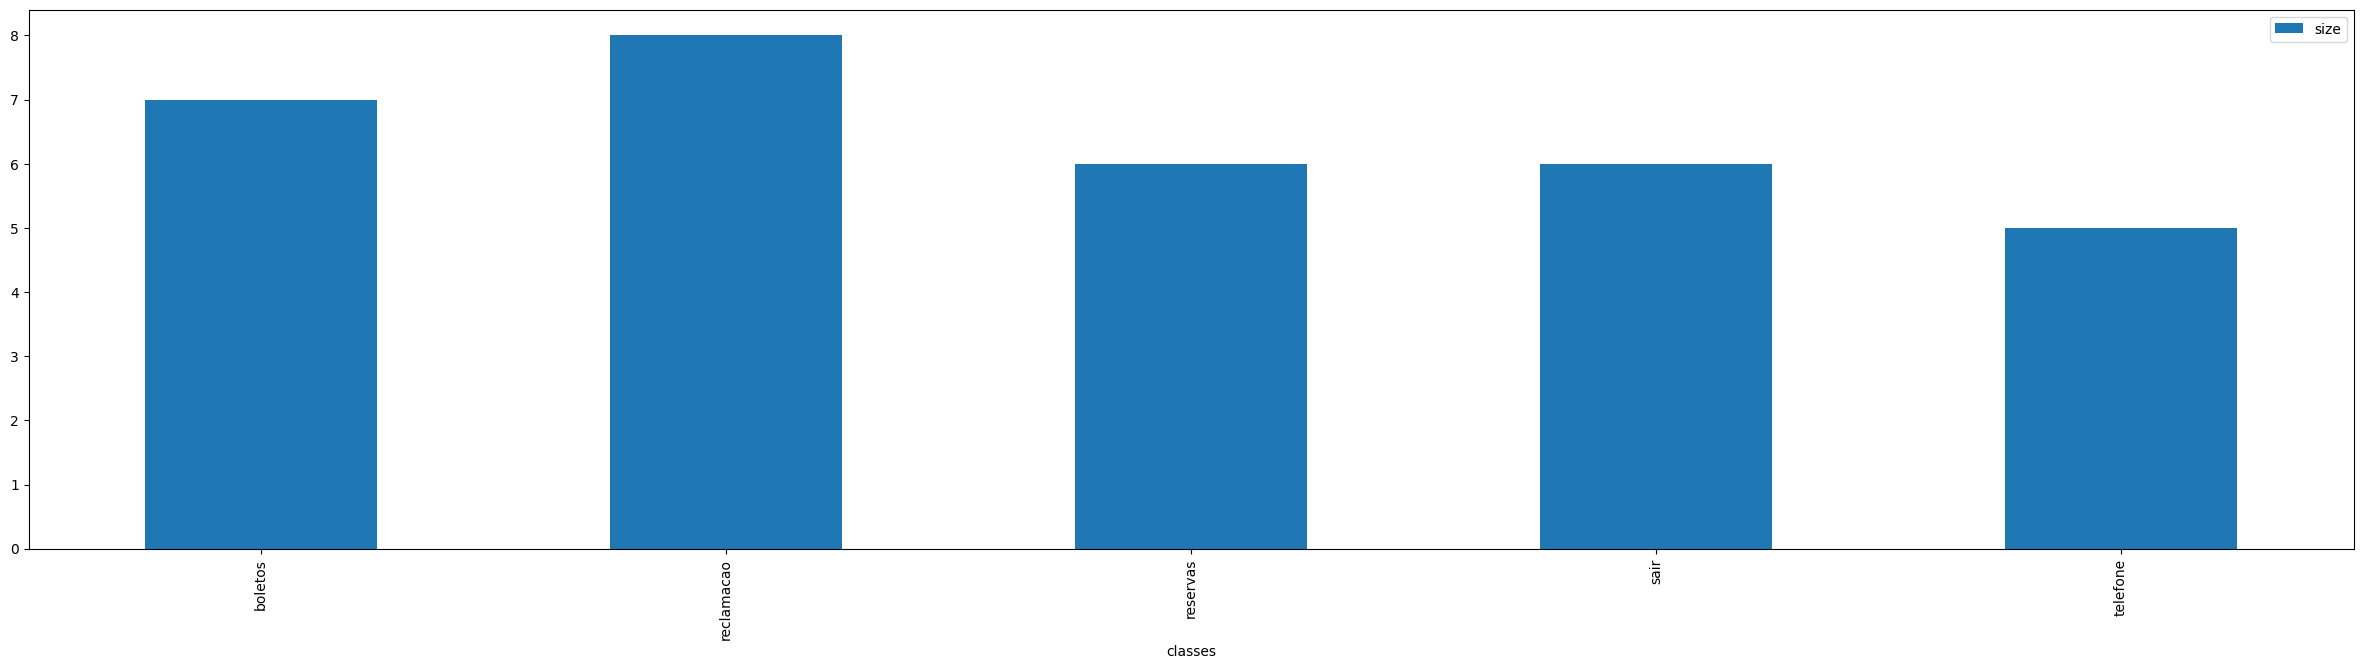

In [9]:
# Buscar lista de intenções do assistant
list_original_intents = assistant.list_intents(
    workspace_id = original_workspace_id
).get_result()

list_original_examples = []
list_original_intent_names = []

# Declaração das variáveis
intent_distribution = pd.DataFrame(columns=['classes', 'size'])
avg_size = 0;

# Montar visualização da distribuição
for idx, intent in enumerate(list_original_intents['intents']):
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = list_original_intents['intents'][idx]['intent']
    ).get_result()
    avg_size = avg_size + len(examples['examples'])
    for example in examples['examples']:
        list_original_examples.append(example['text'])
        list_original_intent_names.append(list_original_intents['intents'][idx]['intent'])
        intent_distribution.loc[idx] = pd.Series({'classes':list_original_intents['intents'][idx]['intent'], 'size': len(examples['examples'])})

# Imprimir o gráfico na tela
intent_distribution.plot(kind='bar',x='classes', y='size',figsize=(30,7))

# Montar o data frame
intent_distribution = pd.DataFrame({
    'Example': list_original_examples,
    'Intent': list_original_intent_names
}, columns=['Example','Intent'])

---
#### 2) Quantidade de conversas e mensagens




In [10]:
def get_watson_conversations_log(workspace_id):
    # Buscar objeto com o log da conversação
    response = assistant.list_logs(
        workspace_id = workspace_id, 
        page_limit = 100
    ).get_result()
    watson_conversation_log = []
    cursor_regex = r".*?cursor=(.*?)&"
    logs = response['logs']
    page = response['pagination']

    # Laço para buscar informações do log
    while response:
        for log in logs:
            watson_conversation_log.append(log)
    
        if not page: #'pagination' not in response or 'next_url' not in response['pagination']:
            break
        
        # Atualiza link do cursor
        cursor_res = re.search(cursor_regex, page['next_url'], re.IGNORECASE)
        cursor = None
        
        if cursor_res:
            cursor = cursor_res.group(1)
        if not cursor:
            break

        # Buscar logs da próxima página 
        response = assistant.list_logs(
            workspace_id=workspace_id, 
            page_limit=100, 
            cursor=cursor
        ).get_result()
        
        # Alimenta array de log e paginação
        logs = response['logs']
        page = response['pagination']

    # Retorna lista com logs
    return watson_conversation_log


Total de Conversas: 19
Total de Mensagens Recebidas: 86


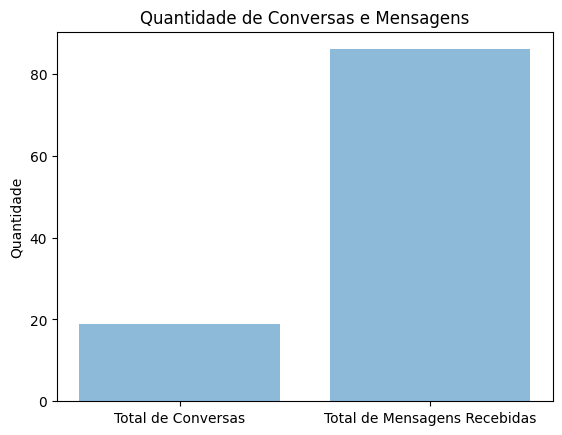

In [12]:
# Buscar logs do Watson
logs_watson = get_watson_conversations_log(original_workspace_id)

def get_intent(log):
    # Retornar as intenções
    if len(log['response']['intents']) == 0:
        return np.nan
    else:
        return log['response']['intents'][0]['intent']

def get_intent_conf(log):
    # Retornar a confiança das intenções
    if len(log['response']['intents']) == 0:
        return np.nan
    else:
        return log['response']['intents'][0]['confidence']

# Instanciar objeto com os campos
was_metrics = pd.DataFrame()
was_metrics['raw_logs'] = logs_watson
was_metrics['conversation_ids'] = [log['response']['context']['conversation_id'] for log in logs_watson]
was_metrics['timestamps'] = [log['request_timestamp'] for log in logs_watson]
was_metrics = was_metrics.assign(iso_date = was_metrics.timestamps.apply(lambda x: date.fromisoformat(x[:10])))
was_metrics = was_metrics.assign(intent = was_metrics.raw_logs.apply(get_intent))
was_metrics = was_metrics.assign(intent_conf = was_metrics.raw_logs.apply(get_intent_conf))

# was_metrics.head()

objects = ('Total de Conversas', 'Total de Mensagens Recebidas')
y_pos = np.arange(len(objects))
quantidade = [len(was_metrics.conversation_ids.unique()),len(was_metrics.iso_date)]

plt.bar(y_pos, quantidade, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Quantidade de Conversas e Mensagens')

print(f"Total de Conversas: {len(was_metrics.conversation_ids.unique())}")
print(f"Total de Mensagens Recebidas: {len(was_metrics.iso_date)}")
plt.show()

---
#### 3) Grau de confiança das intenções

intent
telefone      0.709758
reclamacao    0.950328
reservas      0.977691
boletos       1.000000
sair          1.000000
Name: intent_conf, dtype: float64


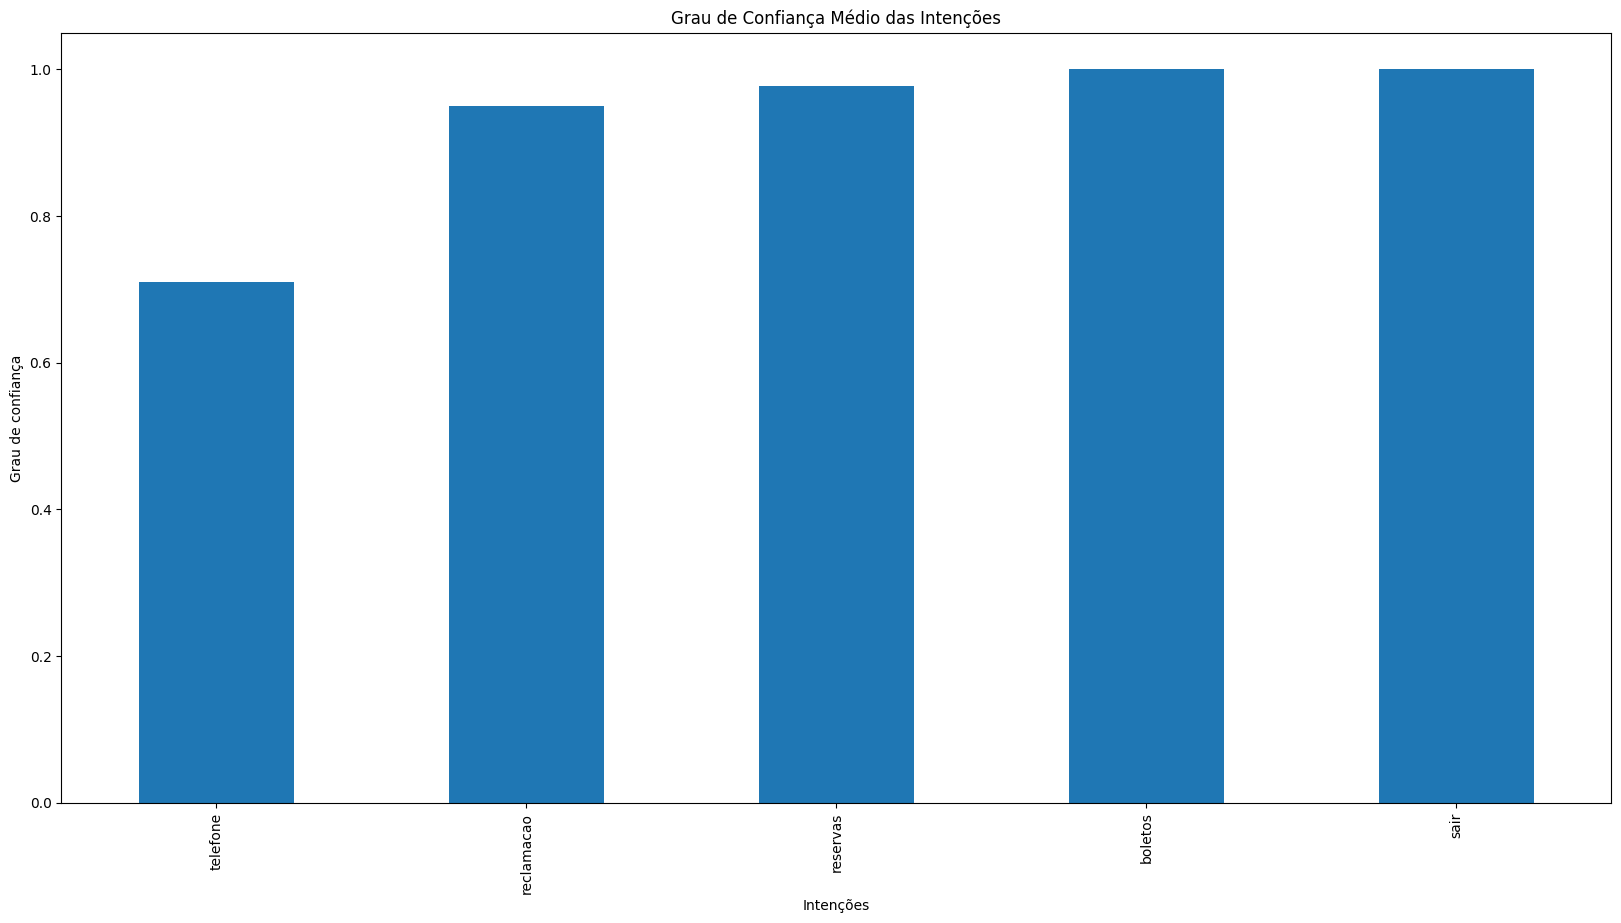

In [39]:
# Retorna confiança das intenções
grau_confianca_medio_intent = was_metrics.groupby('intent').mean().intent_conf.sort_values()
print(grau_confianca_medio_intent)

# Cria grafico de barras indicando número de ocorrência das intenções
s = pd.Series(grau_confianca_medio_intent,
               name='Grau de confiança média da classificação da intenção')
s.plot(
    kind="bar", 
    figsize=(20,10),
    title = "Grau de Confiança Médio das Intenções",
    xlabel='Intenções', 
    ylabel='Grau de confiança'
    )

plt.show()
